# CNN model

In [1]:
%matplotlib inline

import random
from time import time
import gzip

from matplotlib import pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Flatten, Reshape, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

# specify a seed for repeating the exactly results
np.random.seed(seed=28213)

# Set environment variables

## Set number of GPUs

In [2]:
import os
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# On DGX-1 you might need to set the following environment variable for maximum performance:
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [3]:
# print out local devices visible to TensorFlow
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11392848910496654171, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2293465396689876192
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8030448880683684228
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15567726183
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8928112099174608762
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:0b:00.0, compute capability: 7.0"]

# Load data and remove the NAs

In [4]:
# load data
genotype_file = 'data/genotype_full.txt'
genotype = pd.read_csv(genotype_file, sep='\t', index_col=0)
print('genotype_file shape:', genotype.shape)

genotype_file shape: (4390, 28220)


In [5]:
genotype[genotype == -1] = 0
genotype.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
SAMID,,,,,,,,,,,,,,,,,,,,,
01_01,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
01_02,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
01_03,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# phenotype
phenotype_file = 'data/phenotype.csv'
multi_pheno = pd.read_csv(phenotype_file, sep=',', index_col=0)
print('phenotype_multi shape:', multi_pheno.shape)

phenotype_multi shape: (4390, 20)


In [7]:
multi_pheno.head()

,1_CobaltChloride_1,1_CopperSulfate_1,1_Diamide_1,1_E6-Berbamine_1,1_Ethanol_1,1_Formamide_1,1_Hydroxyurea_1,1_IndolaceticAcid_1,1_Lactate_1,1_Lactose_1,1_MagnesiumChloride_1,1_ManganeseSulfate_1,1_Menadione_1,1_Neomycin_1,1_Raffinose_1,1_Trehalose_1,1_Xylose_1,1_YNB_1,1_YPD_1,1_Zeocin_1
01_01,-2.253831,-1.588146,0.194930,-1.055938,-0.250370,0.498227,-0.213244,-0.181865,NaN,-0.847586,-0.352481,1.212162,0.335224,-0.665269,-0.370470,-0.674826,-0.816972,17.711068,25.871208,0.763908
01_02,-1.887746,0.542872,0.451540,0.011593,0.103719,0.828660,0.639112,0.660820,NaN,-0.620460,0.394129,-1.942857,1.397952,-0.313936,1.007102,0.493351,-1.412415,18.286691,26.218803,1.272112
01_03,1.047185,0.453067,0.721835,1.645301,0.427616,-0.326177,-0.141772,-0.611875,-0.797737,-0.219193,-0.108411,0.750178,-0.913395,0.419907,-0.072188,-0.346773,0.169568,15.499536,24.496840,0.072323
01_04,2.417437,0.747427,0.454517,1.856809,-0.135731,0.556514,0.197233,0.371108,NaN,0.666068,0.021487,-0.917218,-0.239386,0.744319,0.033719,1.774186,0.668400,17.301076,25.827809,0.676447
01_06,-1.041743,0.180384,0.464474,-0.966225,-0.338030,-0.728221,0.543498,-1.833931,-0.170299,0.086030,0.108120,-1.251630,-0.038772,-0.670791,-0.233617,-0.199903,-0.283471,15.308695,25.513351,0.996027


In [8]:
X = genotype
Y = multi_pheno.iloc[:, 2]

# take a small part to test code
# X = genotype.iloc[:, 0:10000]
# Y = multi_pheno.iloc[:, 2]

In [9]:
# move the gene loci with NA traits
X = X[~Y.isna()]
Y = Y[~Y.isna()]

X.shape, Y.shape

((4309, 28220), (4309,))

In [10]:
# binarize
Y[Y > 0] = 1
Y[Y < 0] = 0

Y = Y.astype('int')
Y.head()

01_01    1
01_02    1
01_03    1
01_04    1
01_06    1
Name: 1_Diamide_1, dtype: int64

In [11]:
len(Y[Y == 1]), len(Y[Y == 0])

(2428, 1881)

# Prepare data 

## downsampling 

In [12]:
majority = 1 
minority = 0

In [13]:
# downsampled majority
majority_downsampled = resample(X.loc[Y[Y == majority].index],
                                replace=True,       
                                n_samples=len(Y[Y == minority]), # match number in majority class
                                random_state=27) # reproducible results

majority_downsampled.shape

(1881, 28220)

In [14]:
X_balanced = pd.concat([X.loc[Y[Y == minority].index], majority_downsampled])

X_balanced.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
01_23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01_26,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
01_33,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
01_36,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
01_39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
Y_balanced=np.asarray([1]*len(Y[Y == minority])+[0]*len(Y[Y == minority]))

len(Y_balanced)

3762

## One-hot encoding

In [16]:
X_onehot = to_categorical(X_balanced)

X_onehot.shape

(3762, 28220, 2)

## Split train and test

In [17]:
# split df to train and valid
X_train, X_test, Y_train, Y_test = train_test_split(
    X_onehot, Y_balanced, test_size=0.1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3385, 28220, 2), (377, 28220, 2), (3385,), (377,))

In [18]:
# split df to train and valid
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, test_size=0.1)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((3046, 28220, 2), (339, 28220, 2), (3046,), (339,))

# Method 

## Build autoencoder model

In [19]:
# hyperparameters
batch_size = 16
learning_rate = 0.0001
epochs = 100

# conv 1D
num_kernels = 16
feature_size = X_train.shape[1]
inChannel = 2
kr = 1e-3
drop_prec = 0.50

In [20]:
classifier = Sequential()

classifier.add(
    Conv1D(
        num_kernels,
        5,
        padding='same',
        activation='relu',
        kernel_regularizer=l1_l2(kr),
        input_shape=(feature_size, inChannel)))
classifier.add(AveragePooling1D(pool_size=2))
classifier.add(Dropout(drop_prec))

classifier.add(Flatten())

classifier.add(Dropout(drop_prec))
classifier.add(Dense(1, activation='sigmoid'))

#compile
classifier.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy'])

#summary
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28220, 16)         176       
_________________________________________________________________
average_pooling1d (AveragePo (None, 14110, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14110, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 225760)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 225760)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 225761    
Total params: 225,937
Trainable params: 225,937
Non-trainable params: 0
_________________________________________________________________


## Training

In [21]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None
)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/CNN_checkpoint_model.h5',
    monitor='val_acc',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

In [22]:
classifier_fit = classifier.fit(
    X_train,
    Y_train,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping, ModelCheckpoint]
)

Train on 3046 samples, validate on 339 samples
Epoch 1/100
3046/3046 [==============================] - 5s 2ms/step - loss: 0.6377 - acc: 0.6855 - val_loss: 0.5844 - val_acc: 0.7109
Epoch 2/100
3046/3046 [==============================] - 2s 566us/step - loss: 0.5314 - acc: 0.7597 - val_loss: 0.4905 - val_acc: 0.7611
Epoch 3/100
3046/3046 [==============================] - 2s 561us/step - loss: 0.4841 - acc: 0.7915 - val_loss: 0.4768 - val_acc: 0.7788
Epoch 4/100
3046/3046 [==============================] - 2s 552us/step - loss: 0.4605 - acc: 0.8079 - val_loss: 0.4843 - val_acc: 0.7758
Epoch 5/100
3046/3046 [==============================] - 2s 562us/step - loss: 0.4505 - acc: 0.8070 - val_loss: 0.4664 - val_acc: 0.8083
Epoch 6/100
3046/3046 [==============================] - 2s 554us/step - loss: 0.4351 - acc: 0.8155 - val_loss: 0.4986 - val_acc: 0.7699
Epoch 7/100
3046/3046 [==============================] - 2s 642us/step - loss: 0.4224 - acc: 0.8244 - val_loss: 0.4573 - val_acc: 0.7

3046/3046 [==============================] - 2s 511us/step - loss: 0.2129 - acc: 0.9373 - val_loss: 0.4263 - val_acc: 0.8112
Epoch 61/100
3046/3046 [==============================] - 2s 514us/step - loss: 0.2146 - acc: 0.9327 - val_loss: 0.4334 - val_acc: 0.7994
Epoch 62/100
3046/3046 [==============================] - 2s 511us/step - loss: 0.2076 - acc: 0.9389 - val_loss: 0.4204 - val_acc: 0.8083
Epoch 63/100
3046/3046 [==============================] - 2s 511us/step - loss: 0.2047 - acc: 0.9409 - val_loss: 0.4274 - val_acc: 0.8142
Epoch 64/100
3046/3046 [==============================] - 2s 577us/step - loss: 0.2035 - acc: 0.9422 - val_loss: 0.4418 - val_acc: 0.8142
Epoch 65/100
3046/3046 [==============================] - 2s 532us/step - loss: 0.2101 - acc: 0.9327 - val_loss: 0.4294 - val_acc: 0.8112
Epoch 66/100
3046/3046 [==============================] - 2s 515us/step - loss: 0.2015 - acc: 0.9442 - val_loss: 0.4190 - val_acc: 0.8053
Epoch 67/100
3046/3046 [=======================

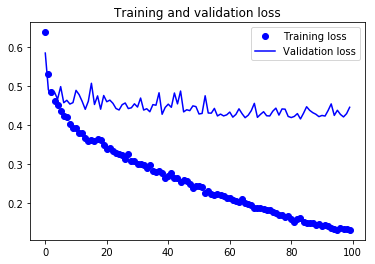

In [23]:
# plot loss curve on validation data
loss = classifier_fit.history['loss']
val_loss = classifier_fit.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

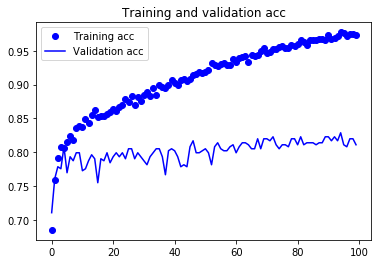

In [24]:
# plot accuracy curve on validation data
acc = classifier_fit.history['acc']
val_acc = classifier_fit.history['val_acc']
plt.figure()
plt.plot(range(len(acc)), acc, 'bo', label='Training acc')
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# Prediction

In [25]:
# load model
# classifier = load_model('models/CNN_checkpoint_model.h5')

In [26]:
# predict
Y_predict = classifier.predict_classes(X_test)

In [27]:
confusion_matrix(Y_test, Y_predict)

array([[152,  29],
       [ 29, 167]])

In [28]:
# acc
accuracy_score(Y_test, Y_predict)

0.8461538461538461

# Plot

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    # print(thresh)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # print(cm[i, j])
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig

Confusion matrix, without normalization
[[152  29]
 [ 29 167]]


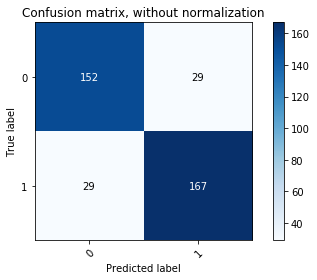

In [30]:
fig=plot_confusion_matrix(Y_test.astype('int'), Y_predict, classes=np.asarray(['0','1']),
                      title='Confusion matrix, without normalization')